# ** CPSC 8810 Deep Learning - HW1-3 **
---

## Introduction
_**Note:** This assignment makes use of the MNIST dataset_

The main objective of this assignments:
* Fit network with random labels
* Compare number of parameters vs generalization
* Compare flatness vs generalization

In [1]:
import tensorflow as tf
import cv2
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.decomposition import PCA

tf.__version__
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## MNIST Dataset Preparation and Visualization

In [2]:
data = input_data.read_data_sets('data/MNIST/', one_hot=True);

train_num = data.train.num_examples
valid_num = data.validation.num_examples
test_num = data.test.num_examples
img_flatten = 784
img_size = 28
num_classes = 10
print("Training Dataset Size:",train_num)
print("Validation Dataset Size:",valid_num)
print("Testing Dataset Size:",test_num)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Training Dataset Size: 55000
Validation Dataset Size: 5000
Testing Dataset Size: 10000


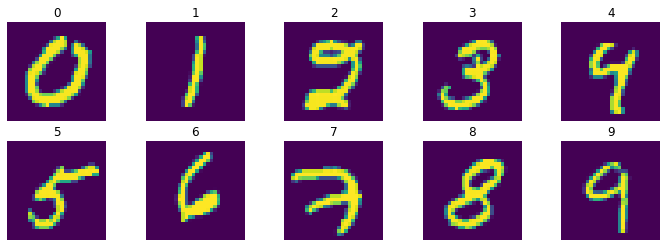

In [3]:
fig, axs = plt.subplots(2,5)
fig.set_size_inches(12,4)
for i in range(10):
    idx = np.where(np.argmax(data.train.labels,1)==i)[0][0]
    axs[int(i/5),i%5].imshow(data.train.images[idx].reshape(28,28))
    axs[int(i/5),i%5].set_title(str(i))
    axs[int(i/5),i%5].axis('off')

### CIFAR-10 Data Distribution Before Augmentation

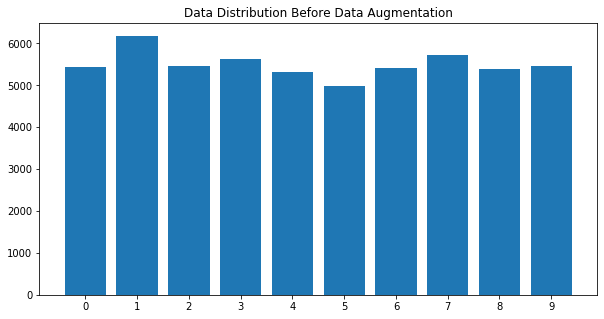

In [4]:
bar_fig = plt.figure(figsize=[10,5])
unique, counts = np.unique(np.argmax(data.train.labels,1), return_counts=True)
plt.bar(unique,counts)
plt.title("Data Distribution Before Data Augmentation")
plt.xticks(unique,np.arange(10));

### Parameter Count Function

In [5]:
def parameter_count():
    total_parameters = 0
    for variable in tf.trainable_variables():
        print(variable)
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        #print("parameter num:",variable_parameters)
        total_parameters += variable_parameters
    print("Total Parameter: ",total_parameters)
    return total_parameters

## 1.1 Model 1 Architecture

In [6]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=8,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=16,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=2,strides=2);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=128,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param1 = parameter_count()

Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(8,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(1

In [7]:
flat1.shape

TensorShape([Dimension(None), Dimension(784)])

### 1.2 Training Model 1

In [181]:
train_loss_list1 = []
train_acc_list1 = []
test_loss_list1 = []
test_acc_list1 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    train_loss_list1.append(train_loss)
    train_acc_list1.append(train_acc)
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    test_loss_list1.append(test_loss)
    test_acc_list1.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.0242676, Training Accuracy: 100.0%, Test Loss: 0.0455143, Test Accuracy:  98.6%


___
## 2.1 Model 2 Architecture

In [204]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=6,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=24,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=2,strides=2);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=32,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param2 = parameter_count()

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 6) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(6,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 6, 24) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(24,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(1176, 32) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(32, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>
Total Parameter:  41774


### 2.2 Model 2 Training

In [207]:
train_loss_list2 = []
train_acc_list2 = []
test_loss_list2 = []
test_acc_list2 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    train_loss_list2.append(train_loss)
    train_acc_list2.append(train_acc)
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    test_loss_list2.append(test_loss)
    test_acc_list2.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.0415243, Training Accuracy:  98.4%, Test Loss: 0.0632147, Test Accuracy:  97.9%


___
## 3.1 Model 3 Architecture

In [208]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=4,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=8,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=2,strides=2);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=32,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param3 = parameter_count()

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 4) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 4, 8) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(8,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(392, 32) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(32, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>
Total Parameter:  13818


### 3.2 Model 3 Training

In [211]:
train_loss_list3= []
train_acc_list3 = []
test_loss_list3 = []
test_acc_list3 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    train_loss_list3.append(train_loss)
    train_acc_list3.append(train_acc)
    test_loss_list3.append(test_loss)
    test_acc_list3.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.055768, Training Accuracy:  98.4%, Test Loss: 0.0827598, Test Accuracy:  97.5%


___
## 4.1 Model 4 Architecture

In [152]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=4,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=8,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=2,strides=2);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=10,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param4 = parameter_count()

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 4) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 4, 8) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(8,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(392, 10) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>
Total Parameter:  4952


### 4.2 Model 4 Training

In [153]:
train_loss_list4= []
train_acc_list4 = []
test_loss_list4 = []
test_acc_list4 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    train_loss_list4.append(train_loss)
    train_acc_list4.append(train_acc)
    test_loss_list4.append(test_loss)
    test_acc_list4.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.0788704, Training Accuracy:  98.4%, Test Loss: 0.0825054, Test Accuracy:  97.3%


___
## 5.1 Model 5 Architecture

In [154]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=4,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=4,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=2,strides=2);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=10,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param5 = parameter_count()

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 4) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 4, 4) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(196, 10) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>
Total Parameter:  2588


### 5.2 Model 5 Training

In [155]:
train_loss_list5= []
train_acc_list5 = []
test_loss_list5 = []
test_acc_list5 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    train_loss_list5.append(train_loss)
    train_acc_list5.append(train_acc)
    test_loss_list5.append(test_loss)
    test_acc_list5.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.0727373, Training Accuracy:  96.9%, Test Loss: 0.111438, Test Accuracy:  96.6%


___
## 6.1 Model 6 Architecture

In [156]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=4,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=6,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=4,strides=4);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=10,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param6 = parameter_count()

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 4) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 4, 6) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(6,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(54, 10) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>
Total Parameter:  1370


### 6.2 Model 6 Training

In [157]:
train_loss_list6= []
train_acc_list6 = []
test_loss_list6 = []
test_acc_list6 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    train_loss_list6.append(train_loss)
    train_acc_list6.append(train_acc)
    test_loss_list6.append(test_loss)
    test_acc_list6.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.141093, Training Accuracy:  93.8%, Test Loss: 0.169575, Test Accuracy:  94.9%


___
## 7.1 Model 7 Architecture

In [158]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=2,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=4,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=4,strides=4);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=10,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param7 = parameter_count()

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 2) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(2,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 2, 4) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(36, 10) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>
Total Parameter:  736


### 7.2 Model 7 Architecture

In [159]:
train_loss_list7= []
train_acc_list7 = []
test_loss_list7 = []
test_acc_list7 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    train_loss_list7.append(train_loss)
    train_acc_list7.append(train_acc)
    test_loss_list7.append(test_loss)
    test_acc_list7.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.380922, Training Accuracy:  92.2%, Test Loss: 0.393909, Test Accuracy:  86.0%


___
## 8.1 Model 8 Architecture

In [160]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=2,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=2,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=4,strides=4);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=10,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param8 = parameter_count()

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 2) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(2,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 2, 2) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(2,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(18, 10) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>
Total Parameter:  454


### 8.2 Model 8 Training

In [161]:
train_loss_list8= []
train_acc_list8 = []
test_loss_list8 = []
test_acc_list8 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
        
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    train_loss_list8.append(train_loss)
    train_acc_list8.append(train_acc)
    test_loss_list8.append(test_loss)
    test_acc_list8.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.280267, Training Accuracy:  89.1%, Test Loss: 0.344693, Test Accuracy:  89.4%


___
## 9.1 Model Architecture

In [162]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=1,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=1,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=4,strides=4);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=10,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param9 = parameter_count()

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 1) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 1, 1) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(9, 10) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>
Total Parameter:  262


# 9.2 Model 9 Training

In [163]:
train_loss_list9= []
train_acc_list9 = []
test_loss_list9 = []
test_acc_list9 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    train_loss_list9.append(train_loss)
    train_acc_list9.append(train_acc)
    test_loss_list9.append(test_loss)
    test_acc_list9.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.427875, Training Accuracy:  84.4%, Test Loss: 0.495387, Test Accuracy:  84.5%


___
## 10.1 Model 10 Architecture

In [214]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=1,kernel_size=3,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=1,kernel_size=3,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=4,strides=4);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=10,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);

param10 = parameter_count()

<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 1) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 1) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(9, 10) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>
Total Parameter:  230


### 10.2 Model 10 Training

In [215]:
train_loss_list10= []
train_acc_list10 = []
test_loss_list10 = []
test_acc_list10 = []

session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
EPOCH = 1
for i in range(EPOCH):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):

        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    test_loss, test_acc = session.run([loss,acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    train_loss_list10.append(train_loss)
    train_acc_list10.append(train_acc)
    test_loss_list10.append(test_loss)
    test_acc_list10.append(test_acc)
    msg = "Epoch: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.6}, Test Accuracy: {4:>6.1%}"
    print(msg.format(i, train_loss, train_acc, test_loss, test_acc))

Epoch:      0, Training Loss: 0.836661, Training Accuracy:  70.3%, Test Loss: 0.76943, Test Accuracy:  74.8%


In [216]:
train_loss_list = np.concatenate([train_loss_list10,train_loss_list9,train_loss_list8,train_loss_list7,train_loss_list6,train_loss_list5,train_loss_list4,train_loss_list3,train_loss_list2,train_loss_list1])

train_acc_list = np.concatenate([train_acc_list10,train_acc_list9,train_acc_list8,train_acc_list7,train_acc_list6,train_acc_list5,train_acc_list4,train_acc_list3,train_acc_list2,train_acc_list1])

test_loss_list = np.concatenate([test_loss_list10,test_loss_list9,test_loss_list8,test_loss_list7,test_loss_list6,test_loss_list5,test_loss_list4,test_loss_list3,test_loss_list2,test_loss_list1])

test_acc_list = np.concatenate([test_acc_list10,test_acc_list9,test_acc_list8,test_acc_list7,test_acc_list6,test_acc_list5,test_acc_list4,test_acc_list3,test_acc_list2,test_acc_list1])

param_num = np.array([param10,param9,param8,param7,param6,param5,param4,param3,param2,param1])

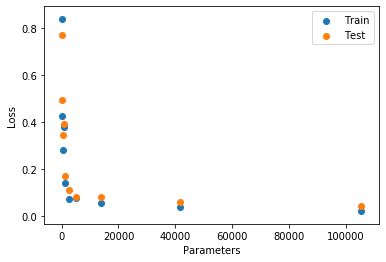

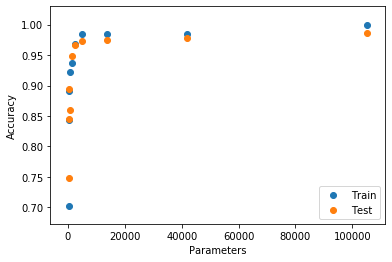

In [219]:
plt.scatter(param_num,train_loss_list)
plt.scatter(param_num,test_loss_list)
plt.xlabel('Parameters')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.pause(0.1)
plt.scatter(param_num,train_acc_list)
plt.scatter(param_num,test_acc_list)
plt.xlabel('Parameters')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])